In [1]:
import os,sys
curr_path = os.getcwd()
sys.path.append('../../codes')
os.environ["CUDA_VISIBLE_DEVICES"] = "1,2"
import datetime
curr_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")  # obtain current time

import torch
from itertools import count
import gym
from agent import Agent
# from memory import ReplayBuffer,NaivePrioritizedBuffer,NStepReplayBuffer
from common.plot import plot_rewards
from common.utils import save_results,make_dir

# multi-envs + 1 agent

In [2]:
from common.atari_wrappers import make_atari, wrap_deepmind, wrap_pytorch
import tianshou as ts
# from common.multiprocessing_env import SubprocVecEnv
# from replay_buffer import PrioritizedReplayBuffer

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [3]:
# !pip install box2d-py # for box2d envs
def make_env(env_id,seed=1):
    if 'Pong' in env_id:
        env = make_atari(env_id)
        env = wrap_deepmind(env,episode_life=True)
        env = wrap_pytorch(env) 
    else:
        env = gym.make(env_id)
    if seed: env.seed(seed)
    return env
def init_envs_agent(cfg,nenv,seed=1):
    envs = ts.env.ShmemVectorEnv([lambda: make_env(cfg.env_id,seed) for _ in range(nenv)])
#     envs = ts.env.SubprocVectorEnv([lambda: make_env(cfg.env_id,seed) for _ in range(nenv)])
    if len(envs.observation_space[0].shape) == 1:
        state_dim = envs.observation_space[0].shape[0]
    else:
        state_dim = envs.observation_space[0].shape
        
    if 'Continuous' in cfg.model:
        cfg.max_act = envs.action_space[0].high[0]
        action_dim = envs.action_space[0].shape[0]
    else:
        action_dim = envs.action_space[0].n
        
    agent = Agent(state_dim,action_dim,cfg)
    return envs,agent
    
#<ImageToPyTorch<ClipRewardEnv<WarpFrame<FireResetEnv<EpisodicLifeEnv<MaxAndSkipEnv<NoopResetEnv<TimeLimit<AtariEnv<PongNoFrameskip-v4>>>>>>>>>>

In [4]:
def train(cfg,envs,agent):
    np.random.seed(cfg.seed)
    torch.manual_seed(cfg.seed)
    envs.seed(cfg.seed)
    
    print('Start Training!')
    time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    print(time)

    history = {}
    history['rewards'], history['ma_rewards'],history['frames'],history['loss']  = [],[],[],[]
    eps_frames,eps_rewards = np.zeros(cfg.n_train_env),np.zeros(cfg.n_train_env)
    i_frame,prev_frame = 0,0
    prev_frame_verbose, prev_frame_save = -1000,0
    buffer = []

    states = envs.reset()
    while i_frame < cfg.max_train_frames: #1500000: #
        
        ### interactive with environments ###
        for _ in range(cfg.n_multi_step):
            values, dists, actions = agent.sample(states)
            #if cfg.n_train_env == 1: actions = [actions]
            #actions = np.random.randint(6,size=cfg.n_train_env)
            next_states,rewards,dones,infos = envs.step(actions.cpu().detach().numpy())
            eps_rewards += rewards
            done_envs_ids = np.where(dones)[0]
            eps_frames += 1
            rewards = torch.as_tensor(rewards,device=cfg.device, dtype=torch.float32).unsqueeze(1)
            dones = torch.as_tensor(np.float32(dones), device=cfg.device).unsqueeze(1)
            buffer.append((values, dists, actions, rewards, dones))
            states = next_states
            i_frame += len(actions)
            
            ### recording historys ###
            if len(done_envs_ids) > 0:
                for r in eps_rewards[done_envs_ids]:
                    history['rewards'].append(r)
                    if history['ma_rewards']:
                        history['ma_rewards'].append(history['ma_rewards'][-1]*0.9+r*0.1)
                    else:
                        history['ma_rewards'].append(r)
                for n in eps_frames[done_envs_ids]:
                    if history['frames']:
                        history['frames'].append(history['frames'][-1] + n)
                    else:
                        history['frames'].append(n)
                eps_frames[done_envs_ids] = 0
                eps_rewards[done_envs_ids] = 0
                states[done_envs_ids] = envs.reset(done_envs_ids)
        
        ### verbose ###
        time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        if history['frames']:
            if history['frames'][-1] - prev_frame_verbose >= 1000:
                prev_frame_verbose = history['frames'][-1]
                if history['loss']:
                    print(f"[{time}: {cfg.agent}] Episode:{len(history['frames'])}: Frame:{history['frames'][-1]}: Reward:{history['rewards'][-1]:.1f}: Loss:{history['loss'][-1]:.4f}")
                else:
                    print(f"[{time}: {cfg.agent}] Episode:{len(history['frames'])}: Frame:{history['frames'][-1]}: Reward:{history['rewards'][-1]:.1f}")
            if history['frames'][-1] - prev_frame_save >= cfg.max_train_frames//10:
                prev_frame_save = history['frames'][-1]
                make_dir(cfg.result_path,cfg.model_path+time)
                agent.save(path=cfg.model_path+time+'/')
                
        ### updating agent ###
        loss = agent.learn(buffer,next_states)
        if loss:
            history['loss'].append(loss)
        del buffer[:]
                    
    make_dir(cfg.result_path,cfg.model_path+time)
    agent.save(path=cfg.model_path+time+'/')
    return history

In [5]:
def evaluate(cfg,envs,agent,render=False):
    envs.seed(1)
    print('Start Evaluating!')
    time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    print(time)

    history = {}
    history['rewards'], history['ma_rewards'],history['frames']  = [],[],[]
    eps_frames,eps_rewards = np.zeros(cfg.n_eval_env),np.zeros(cfg.n_eval_env)
    i_frame,prev_frame = 0,0
    prev_frame_verbose, prev_frame_save = -1000,0

    states = envs.reset()
    while i_frame < cfg.max_eval_frames:
        ### interactive with environments ###
        if render: envs.render()
        _,dist = agent.predict(states)
        actions = dist.sample()
        if cfg.n_eval_env == 1: actions = [actions]
        next_states,rewards,dones,infos = envs.step(actions.cpu().detach().numpy())
        eps_rewards += rewards
        done_envs_ids = np.where(dones)[0]
        eps_frames += 1
        states = next_states
        i_frame += len(actions)

        ### recording historys ###
        if len(done_envs_ids) > 0:
            for r in eps_rewards[done_envs_ids]:
                history['rewards'].append(r)
                if history['ma_rewards']:
                    history['ma_rewards'].append(history['ma_rewards'][-1]*0.9+r*0.1)
                else:
                    history['ma_rewards'].append(r)
            for n in eps_frames[done_envs_ids]:
                if history['frames']:
                    history['frames'].append(history['frames'][-1] + n)
                else:
                    history['frames'].append(n)
            eps_frames[done_envs_ids] = 0
            eps_rewards[done_envs_ids] = 0
            states[done_envs_ids] = envs.reset(done_envs_ids)
            
        ### verbose ###
        time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        if history['frames']:
            if history['frames'][-1] - prev_frame_verbose >= 10:
                prev_frame_verbose = history['frames'][-1]
                print(f"[{time}: {cfg.agent}] Episode:{len(history['frames'])}: Frame:{history['frames'][-1]}: Reward:{history['rewards'][-1]:.1f}")
    return history

In [6]:
def main():
    cfg = config()
    print(cfg.agent,cfg.env_id)
    
    envs,agent = init_envs_agent(cfg,cfg.n_train_env)
    history = train(cfg,envs,agent)
    make_dir(cfg.result_path,cfg.model_path)
    agent.save(path=cfg.model_path)
    save_results(history,tag='train',path=cfg.result_path)
    plot_rewards(history['rewards'],history['ma_rewards'],tag="train",env=cfg.env_id,algo = cfg.agent,path=cfg.result_path)

    eval_envs,agent = init_envs_agent(cfg,cfg.n_eval_env,seed=10)
    agent.load(path=cfg.model_path)
    history = evaluate(cfg,eval_envs,agent,render=False)
    save_results(history,tag='eval',path=cfg.result_path)
    plot_rewards(history['rewards'],history['ma_rewards'],tag="eval",env=cfg.env_id,algo = cfg.agent,path=cfg.result_path)

## PongNoFrameskip-v4

In [19]:
class config:
    def __init__(self):
        self.seed = 1                         # seed
        self.agent = 'GAE'             # name of agent
        self.env_id = 'PongNoFrameskip-v4'    # name of environment
        self.result_path = curr_path+"/outputs/" +self.env_id+'/'+curr_time+'/'+self.agent+'/results/'  # path to save results
        self.model_path = curr_path+"/outputs/" +self.env_id+'/'+curr_time+'/'+self.agent+'/models/'  # path to save models
        self.n_train_env = 16           # number of training environment 
        self.n_eval_env = 4           # number of evaluation environment 
        self.max_train_frames = 5e6     # max number of training frames
        self.max_eval_frames = 5e4      # max number of evaluation frames 
        self.w_critic_loss = 0.25         # weight of critic loss
        self.w_entropy_loss = 0.001      # weight of entropy loss
        self.lr = 0.00014                 # learning rate
        self.gamma = 0.99              # discount rate of reward
        self.tau = 0.99                # discount rate of Advantage function
        self.n_multi_step = 45          # number of steps of multi-step style gain 
        self.model = 'Discrete_CNN'             # name of model
        self.hidden_dim = 512           # dimmension of hidden layer
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # check gpu

GAE PongNoFrameskip-v4
Start Training!
20210803-171944
[20210803-171952: GAE] Episode:15: Frame:11359.0: Reward:-21.0: Loss:0.5662
[20210803-171959: GAE] Episode:31: Frame:23548.0: Reward:-21.0: Loss:0.0050
[20210803-172007: GAE] Episode:47: Frame:35693.0: Reward:-21.0: Loss:0.0274
[20210803-172014: GAE] Episode:63: Frame:47828.0: Reward:-21.0: Loss:0.0517
[20210803-172021: GAE] Episode:78: Frame:59208.0: Reward:-21.0: Loss:0.2580
[20210803-172021: GAE] Episode:80: Frame:60788.0: Reward:-21.0: Loss:0.5991
[20210803-172028: GAE] Episode:87: Frame:66129.0: Reward:-21.0: Loss:0.1653
[20210803-172028: GAE] Episode:91: Frame:69285.0: Reward:-21.0: Loss:0.2100
[20210803-172029: GAE] Episode:93: Frame:71096.0: Reward:-19.0: Loss:0.0155
[20210803-172030: GAE] Episode:95: Frame:72974.0: Reward:-20.0: Loss:-0.0205
[20210803-172031: GAE] Episode:96: Frame:74024.0: Reward:-19.0: Loss:-0.1295
[20210803-172035: GAE] Episode:98: Frame:75618.0: Reward:-21.0: Loss:-0.1083
[20210803-172035: GAE] Episode

[20210803-172228: GAE] Episode:315: Frame:267834.0: Reward:-21.0: Loss:-0.0795
[20210803-172229: GAE] Episode:317: Frame:269471.0: Reward:-21.0: Loss:-0.0481
[20210803-172230: GAE] Episode:319: Frame:271073.0: Reward:-21.0: Loss:0.1813
[20210803-172231: GAE] Episode:321: Frame:272828.0: Reward:-21.0: Loss:0.1143
[20210803-172231: GAE] Episode:323: Frame:274582.0: Reward:-21.0: Loss:0.1734
[20210803-172233: GAE] Episode:325: Frame:276235.0: Reward:-21.0: Loss:-0.0361
[20210803-172234: GAE] Episode:327: Frame:277872.0: Reward:-21.0: Loss:0.0137
[20210803-172235: GAE] Episode:329: Frame:279566.0: Reward:-21.0: Loss:0.1024
[20210803-172236: GAE] Episode:331: Frame:281530.0: Reward:-21.0: Loss:0.0860
[20210803-172237: GAE] Episode:333: Frame:283271.0: Reward:-20.0: Loss:0.0557
[20210803-172238: GAE] Episode:335: Frame:284868.0: Reward:-21.0: Loss:0.0300
[20210803-172239: GAE] Episode:338: Frame:287349.0: Reward:-21.0: Loss:0.0223
[20210803-172240: GAE] Episode:340: Frame:289109.0: Reward:-2

[20210803-172429: GAE] Episode:551: Frame:479440.0: Reward:-19.0: Loss:-0.0219
[20210803-172430: GAE] Episode:553: Frame:481276.0: Reward:-19.0: Loss:-0.1094
[20210803-172432: GAE] Episode:555: Frame:483023.0: Reward:-21.0: Loss:0.0607
[20210803-172434: GAE] Episode:559: Frame:486552.0: Reward:-21.0: Loss:0.1433
[20210803-172436: GAE] Episode:562: Frame:489173.0: Reward:-21.0: Loss:-0.0121
[20210803-172436: GAE] Episode:563: Frame:490326.0: Reward:-20.0: Loss:-0.2690
[20210803-172437: GAE] Episode:566: Frame:493010.0: Reward:-21.0: Loss:-0.0892
[20210803-172438: GAE] Episode:568: Frame:495364.0: Reward:-17.0: Loss:0.1676
[20210803-172439: GAE] Episode:569: Frame:496501.0: Reward:-19.0: Loss:-0.0867
[20210803-172440: GAE] Episode:572: Frame:499259.0: Reward:-20.0: Loss:0.1385
[20210803-172441: GAE] Episode:574: Frame:500930.0: Reward:-21.0: Loss:-0.1468
[20210803-172443: GAE] Episode:576: Frame:502750.0: Reward:-20.0: Loss:0.0034
[20210803-172445: GAE] Episode:579: Frame:505380.0: Rewar

[20210803-172629: GAE] Episode:752: Frame:675906.0: Reward:-20.0: Loss:-0.0719
[20210803-172629: GAE] Episode:755: Frame:679044.0: Reward:-18.0: Loss:0.2135
[20210803-172630: GAE] Episode:756: Frame:680102.0: Reward:-20.0: Loss:0.2271
[20210803-172631: GAE] Episode:757: Frame:681331.0: Reward:-19.0: Loss:-0.1392
[20210803-172632: GAE] Episode:760: Frame:684480.0: Reward:-20.0: Loss:0.0006
[20210803-172632: GAE] Episode:761: Frame:685515.0: Reward:-19.0: Loss:-0.1208
[20210803-172633: GAE] Episode:762: Frame:686538.0: Reward:-20.0: Loss:-0.0427
[20210803-172634: GAE] Episode:763: Frame:687683.0: Reward:-19.0: Loss:0.0700
[20210803-172637: GAE] Episode:765: Frame:689669.0: Reward:-20.0: Loss:0.1281
[20210803-172638: GAE] Episode:767: Frame:691527.0: Reward:-21.0: Loss:-0.0637
[20210803-172639: GAE] Episode:769: Frame:693470.0: Reward:-20.0: Loss:0.0073
[20210803-172641: GAE] Episode:771: Frame:695583.0: Reward:-19.0: Loss:-0.0477
[20210803-172641: GAE] Episode:772: Frame:696635.0: Reward

[20210803-172818: GAE] Episode:906: Frame:856123.0: Reward:-17.0: Loss:-0.0832
[20210803-172819: GAE] Episode:908: Frame:859116.0: Reward:-19.0: Loss:0.0233
[20210803-172820: GAE] Episode:910: Frame:861739.0: Reward:-19.0: Loss:-0.1840
[20210803-172822: GAE] Episode:911: Frame:863110.0: Reward:-19.0: Loss:-0.2795
[20210803-172823: GAE] Episode:912: Frame:864591.0: Reward:-15.0: Loss:-0.0375
[20210803-172824: GAE] Episode:913: Frame:865949.0: Reward:-18.0: Loss:0.2200
[20210803-172824: GAE] Episode:915: Frame:868441.0: Reward:-17.0: Loss:0.2180
[20210803-172827: GAE] Episode:916: Frame:869877.0: Reward:-19.0: Loss:-0.2655
[20210803-172827: GAE] Episode:917: Frame:871184.0: Reward:-20.0: Loss:0.1601
[20210803-172828: GAE] Episode:918: Frame:873038.0: Reward:-14.0: Loss:-0.0974
[20210803-172830: GAE] Episode:919: Frame:874430.0: Reward:-16.0: Loss:-0.2198
[20210803-172830: GAE] Episode:920: Frame:875794.0: Reward:-17.0: Loss:0.0695
[20210803-172831: GAE] Episode:922: Frame:878465.0: Rewar

[20210803-173006: GAE] Episode:1037: Frame:1040257.0: Reward:-18.0: Loss:-0.1302
[20210803-173006: GAE] Episode:1038: Frame:1041822.0: Reward:-17.0: Loss:-0.1812
[20210803-173007: GAE] Episode:1039: Frame:1043023.0: Reward:-18.0: Loss:-0.0672
[20210803-173010: GAE] Episode:1040: Frame:1044301.0: Reward:-18.0: Loss:0.0492
[20210803-173011: GAE] Episode:1041: Frame:1045542.0: Reward:-19.0: Loss:0.0196
[20210803-173011: GAE] Episode:1042: Frame:1046829.0: Reward:-17.0: Loss:0.1000
[20210803-173014: GAE] Episode:1043: Frame:1047942.0: Reward:-19.0: Loss:-0.1199
[20210803-173014: GAE] Episode:1045: Frame:1050428.0: Reward:-18.0: Loss:0.0906
[20210803-173016: GAE] Episode:1046: Frame:1051742.0: Reward:-17.0: Loss:0.2160
[20210803-173017: GAE] Episode:1048: Frame:1054547.0: Reward:-16.0: Loss:0.0946
[20210803-173018: GAE] Episode:1049: Frame:1056154.0: Reward:-13.0: Loss:-0.0517
[20210803-173019: GAE] Episode:1050: Frame:1057563.0: Reward:-16.0: Loss:-0.0516
[20210803-173019: GAE] Episode:105

[20210803-173210: GAE] Episode:1160: Frame:1237265.0: Reward:-20.0: Loss:0.0011
[20210803-173211: GAE] Episode:1162: Frame:1240161.0: Reward:-20.0: Loss:0.1129
[20210803-173212: GAE] Episode:1163: Frame:1241941.0: Reward:-19.0: Loss:-0.0704
[20210803-173213: GAE] Episode:1164: Frame:1243928.0: Reward:-13.0: Loss:-0.0187
[20210803-173215: GAE] Episode:1166: Frame:1247802.0: Reward:-7.0: Loss:0.0819
[20210803-173216: GAE] Episode:1167: Frame:1249425.0: Reward:-16.0: Loss:0.0581
[20210803-173217: GAE] Episode:1168: Frame:1251023.0: Reward:-21.0: Loss:0.1660
[20210803-173217: GAE] Episode:1170: Frame:1254845.0: Reward:-11.0: Loss:0.0709
[20210803-173218: GAE] Episode:1171: Frame:1256431.0: Reward:-19.0: Loss:0.0541
[20210803-173220: GAE] Episode:1172: Frame:1257971.0: Reward:-18.0: Loss:-0.0333
[20210803-173222: GAE] Episode:1173: Frame:1259743.0: Reward:-17.0: Loss:0.0230
[20210803-173224: GAE] Episode:1174: Frame:1261138.0: Reward:-20.0: Loss:0.0599
[20210803-173224: GAE] Episode:1176: F

[20210803-173429: GAE] Episode:1287: Frame:1471872.0: Reward:-8.0: Loss:-0.0177
[20210803-173430: GAE] Episode:1288: Frame:1473620.0: Reward:-18.0: Loss:-0.0041
[20210803-173430: GAE] Episode:1290: Frame:1477529.0: Reward:-5.0: Loss:0.0338
[20210803-173434: GAE] Episode:1291: Frame:1479040.0: Reward:-20.0: Loss:0.0006
[20210803-173434: GAE] Episode:1292: Frame:1480880.0: Reward:-16.0: Loss:0.0936
[20210803-173436: GAE] Episode:1293: Frame:1482920.0: Reward:-11.0: Loss:0.0252
[20210803-173437: GAE] Episode:1294: Frame:1485489.0: Reward:1.0: Loss:-0.0132
[20210803-173439: GAE] Episode:1296: Frame:1489185.0: Reward:-18.0: Loss:0.1259
[20210803-173441: GAE] Episode:1297: Frame:1491319.0: Reward:-10.0: Loss:-0.0735
[20210803-173443: GAE] Episode:1298: Frame:1493579.0: Reward:-7.0: Loss:0.0284
[20210803-173444: GAE] Episode:1299: Frame:1495040.0: Reward:-18.0: Loss:0.0802
[20210803-173445: GAE] Episode:1300: Frame:1496667.0: Reward:-16.0: Loss:0.0022
[20210803-173446: GAE] Episode:1301: Fram

[20210803-173700: GAE] Episode:1406: Frame:1725360.0: Reward:-10.0: Loss:-0.0128
[20210803-173702: GAE] Episode:1407: Frame:1728120.0: Reward:2.0: Loss:0.0261
[20210803-173706: GAE] Episode:1409: Frame:1732952.0: Reward:-8.0: Loss:0.0158
[20210803-173706: GAE] Episode:1410: Frame:1735241.0: Reward:-8.0: Loss:0.0014
[20210803-173707: GAE] Episode:1411: Frame:1738093.0: Reward:3.0: Loss:-0.0306
[20210803-173710: GAE] Episode:1412: Frame:1740514.0: Reward:-8.0: Loss:0.0535
[20210803-173711: GAE] Episode:1413: Frame:1742550.0: Reward:-11.0: Loss:0.0462
[20210803-173711: GAE] Episode:1414: Frame:1744881.0: Reward:-8.0: Loss:0.0362
[20210803-173713: GAE] Episode:1415: Frame:1747379.0: Reward:7.0: Loss:-0.0152
[20210803-173718: GAE] Episode:1416: Frame:1749878.0: Reward:6.0: Loss:0.0096
[20210803-173719: GAE] Episode:1417: Frame:1752768.0: Reward:-1.0: Loss:0.0274
[20210803-173719: GAE] Episode:1418: Frame:1755445.0: Reward:-6.0: Loss:0.0866
[20210803-173719: GAE] Episode:1419: Frame:1758039.

[20210803-174004: GAE] Episode:1522: Frame:2030610.0: Reward:-6.0: Loss:0.1566
[20210803-174006: GAE] Episode:1523: Frame:2033779.0: Reward:-1.0: Loss:-0.0399
[20210803-174007: GAE] Episode:1524: Frame:2036439.0: Reward:8.0: Loss:-0.0101
[20210803-174009: GAE] Episode:1525: Frame:2039559.0: Reward:3.0: Loss:-0.0336
[20210803-174010: GAE] Episode:1527: Frame:2045003.0: Reward:10.0: Loss:0.0244
[20210803-174011: GAE] Episode:1528: Frame:2047668.0: Reward:7.0: Loss:-0.0571
[20210803-174011: GAE] Episode:1529: Frame:2050276.0: Reward:11.0: Loss:0.0381
[20210803-174015: GAE] Episode:1530: Frame:2053389.0: Reward:-2.0: Loss:0.0179
[20210803-174019: GAE] Episode:1531: Frame:2056217.0: Reward:8.0: Loss:0.0212
[20210803-174020: GAE] Episode:1532: Frame:2059470.0: Reward:1.0: Loss:-0.0032
[20210803-174023: GAE] Episode:1533: Frame:2062625.0: Reward:2.0: Loss:0.0232
[20210803-174023: GAE] Episode:1534: Frame:2065030.0: Reward:10.0: Loss:0.0128
[20210803-174027: GAE] Episode:1535: Frame:2067136.0:

[20210803-174247: GAE] Episode:1637: Frame:2326067.0: Reward:18.0: Loss:0.0070
[20210803-174248: GAE] Episode:1638: Frame:2328882.0: Reward:7.0: Loss:0.0369
[20210803-174251: GAE] Episode:1639: Frame:2330672.0: Reward:20.0: Loss:-0.0036
[20210803-174251: GAE] Episode:1640: Frame:2332305.0: Reward:21.0: Loss:0.0381
[20210803-174253: GAE] Episode:1641: Frame:2334142.0: Reward:18.0: Loss:0.0013
[20210803-174253: GAE] Episode:1642: Frame:2335923.0: Reward:19.0: Loss:-0.0046
[20210803-174258: GAE] Episode:1644: Frame:2340712.0: Reward:15.0: Loss:0.0012
[20210803-174259: GAE] Episode:1645: Frame:2343782.0: Reward:2.0: Loss:-0.0172
[20210803-174259: GAE] Episode:1646: Frame:2346741.0: Reward:7.0: Loss:0.0148
[20210803-174259: GAE] Episode:1647: Frame:2349733.0: Reward:4.0: Loss:0.0396
[20210803-174301: GAE] Episode:1650: Frame:2354973.0: Reward:19.0: Loss:-0.0253
[20210803-174303: GAE] Episode:1651: Frame:2356772.0: Reward:18.0: Loss:0.0384
[20210803-174305: GAE] Episode:1652: Frame:2358403.0

[20210803-174536: GAE] Episode:1756: Frame:2612681.0: Reward:6.0: Loss:-0.0451
[20210803-174537: GAE] Episode:1757: Frame:2616024.0: Reward:-2.0: Loss:-0.0036
[20210803-174541: GAE] Episode:1758: Frame:2619126.0: Reward:4.0: Loss:0.0615
[20210803-174542: GAE] Episode:1759: Frame:2621328.0: Reward:14.0: Loss:0.0078
[20210803-174543: GAE] Episode:1760: Frame:2624424.0: Reward:8.0: Loss:-0.0243
[20210803-174544: GAE] Episode:1761: Frame:2626749.0: Reward:14.0: Loss:0.0186
[20210803-174544: GAE] Episode:1763: Frame:2631801.0: Reward:8.0: Loss:0.0604
[20210803-174545: GAE] Episode:1765: Frame:2638034.0: Reward:4.0: Loss:0.0150
[20210803-174547: GAE] Episode:1766: Frame:2641122.0: Reward:7.0: Loss:0.1169
[20210803-174549: GAE] Episode:1767: Frame:2644106.0: Reward:9.0: Loss:-0.0327
[20210803-174551: GAE] Episode:1768: Frame:2647693.0: Reward:2.0: Loss:-0.0422
[20210803-174554: GAE] Episode:1769: Frame:2649675.0: Reward:18.0: Loss:0.0302
[20210803-174555: GAE] Episode:1770: Frame:2653139.0: R

[20210803-174810: GAE] Episode:1876: Frame:2900796.0: Reward:21.0: Loss:0.0257
[20210803-174815: GAE] Episode:1877: Frame:2903795.0: Reward:12.0: Loss:-0.0492
[20210803-174816: GAE] Episode:1880: Frame:2910284.0: Reward:13.0: Loss:0.0606
[20210803-174816: GAE] Episode:1881: Frame:2911971.0: Reward:20.0: Loss:-0.0382
[20210803-174818: GAE] Episode:1883: Frame:2916946.0: Reward:12.0: Loss:-0.0005
[20210803-174820: GAE] Episode:1884: Frame:2918808.0: Reward:19.0: Loss:0.0585
[20210803-174822: GAE] Episode:1885: Frame:2920496.0: Reward:21.0: Loss:0.0010
[20210803-174823: GAE] Episode:1886: Frame:2922187.0: Reward:21.0: Loss:-0.0095
[20210803-174828: GAE] Episode:1887: Frame:2925390.0: Reward:9.0: Loss:0.0340
[20210803-174829: GAE] Episode:1888: Frame:2928389.0: Reward:9.0: Loss:0.0174
[20210803-174832: GAE] Episode:1889: Frame:2930080.0: Reward:21.0: Loss:0.0320
[20210803-174833: GAE] Episode:1890: Frame:2931926.0: Reward:20.0: Loss:0.0256
[20210803-174833: GAE] Episode:1891: Frame:2933616

[20210803-175046: GAE] Episode:1992: Frame:3179442.0: Reward:21.0: Loss:-0.0063
[20210803-175049: GAE] Episode:1993: Frame:3181129.0: Reward:21.0: Loss:0.0126
[20210803-175050: GAE] Episode:1994: Frame:3182819.0: Reward:21.0: Loss:-0.0017
[20210803-175051: GAE] Episode:1995: Frame:3184509.0: Reward:21.0: Loss:0.0211
[20210803-175053: GAE] Episode:1996: Frame:3187459.0: Reward:14.0: Loss:-0.0223
[20210803-175054: GAE] Episode:1997: Frame:3190645.0: Reward:12.0: Loss:0.0068
[20210803-175055: GAE] Episode:1998: Frame:3193698.0: Reward:11.0: Loss:0.0309
[20210803-175056: GAE] Episode:1999: Frame:3196738.0: Reward:11.0: Loss:-0.0101
[20210803-175057: GAE] Episode:2000: Frame:3198429.0: Reward:21.0: Loss:-0.0067
[20210803-175058: GAE] Episode:2001: Frame:3200615.0: Reward:17.0: Loss:0.0075
[20210803-175058: GAE] Episode:2002: Frame:3202776.0: Reward:16.0: Loss:0.0367
[20210803-175059: GAE] Episode:2003: Frame:3205867.0: Reward:9.0: Loss:0.0132
[20210803-175101: GAE] Episode:2004: Frame:32088

[20210803-175308: GAE] Episode:2106: Frame:3448946.0: Reward:12.0: Loss:-0.0124
[20210803-175310: GAE] Episode:2107: Frame:3451873.0: Reward:14.0: Loss:-0.0128
[20210803-175311: GAE] Episode:2108: Frame:3453578.0: Reward:20.0: Loss:-0.0164
[20210803-175314: GAE] Episode:2109: Frame:3456584.0: Reward:13.0: Loss:0.0207
[20210803-175315: GAE] Episode:2110: Frame:3459613.0: Reward:14.0: Loss:-0.0052
[20210803-175316: GAE] Episode:2111: Frame:3461421.0: Reward:19.0: Loss:0.0024
[20210803-175317: GAE] Episode:2112: Frame:3463181.0: Reward:20.0: Loss:0.0079
[20210803-175322: GAE] Episode:2114: Frame:3467834.0: Reward:21.0: Loss:0.0197
[20210803-175323: GAE] Episode:2115: Frame:3469799.0: Reward:19.0: Loss:0.0173
[20210803-175325: GAE] Episode:2116: Frame:3471490.0: Reward:21.0: Loss:-0.0153
[20210803-175326: GAE] Episode:2118: Frame:3476309.0: Reward:11.0: Loss:-0.0179
[20210803-175326: GAE] Episode:2119: Frame:3479277.0: Reward:13.0: Loss:0.0163
[20210803-175327: GAE] Episode:2120: Frame:348

[20210803-175553: GAE] Episode:2224: Frame:3736792.0: Reward:20.0: Loss:-0.0169
[20210803-175554: GAE] Episode:2225: Frame:3738996.0: Reward:17.0: Loss:0.0235
[20210803-175557: GAE] Episode:2226: Frame:3742032.0: Reward:13.0: Loss:0.0377
[20210803-175558: GAE] Episode:2227: Frame:3745140.0: Reward:10.0: Loss:0.0331
[20210803-175603: GAE] Episode:2228: Frame:3748380.0: Reward:10.0: Loss:-0.0124
[20210803-175604: GAE] Episode:2229: Frame:3750070.0: Reward:21.0: Loss:-0.0038
[20210803-175604: GAE] Episode:2230: Frame:3751756.0: Reward:21.0: Loss:-0.0121
[20210803-175606: GAE] Episode:2231: Frame:3753447.0: Reward:21.0: Loss:0.0040
[20210803-175607: GAE] Episode:2232: Frame:3756413.0: Reward:12.0: Loss:0.0067
[20210803-175607: GAE] Episode:2233: Frame:3759415.0: Reward:11.0: Loss:0.0290
[20210803-175608: GAE] Episode:2235: Frame:3762866.0: Reward:21.0: Loss:0.0189
[20210803-175613: GAE] Episode:2236: Frame:3765848.0: Reward:11.0: Loss:-0.0037
[20210803-175613: GAE] Episode:2237: Frame:3768

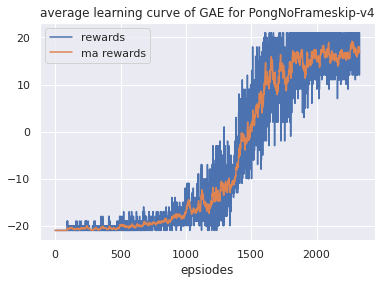

Start Evaluating!
20210803-175824
[20210803-175831: GAE] Episode:1: Frame:1691.0: Reward:21.0
[20210803-175836: GAE] Episode:2: Frame:4627.0: Reward:14.0
[20210803-175837: GAE] Episode:3: Frame:7729.0: Reward:9.0
[20210803-175837: GAE] Episode:4: Frame:10863.0: Reward:11.0
[20210803-175839: GAE] Episode:5: Frame:12617.0: Reward:20.0
[20210803-175844: GAE] Episode:6: Frame:14307.0: Reward:21.0
[20210803-175845: GAE] Episode:7: Frame:15995.0: Reward:21.0
[20210803-175851: GAE] Episode:8: Frame:18906.0: Reward:10.0
[20210803-175853: GAE] Episode:9: Frame:20610.0: Reward:20.0
[20210803-175853: GAE] Episode:10: Frame:23533.0: Reward:13.0
[20210803-175854: GAE] Episode:11: Frame:25320.0: Reward:20.0
[20210803-175902: GAE] Episode:12: Frame:27104.0: Reward:20.0
[20210803-175902: GAE] Episode:13: Frame:28939.0: Reward:20.0
[20210803-175907: GAE] Episode:14: Frame:32087.0: Reward:10.0
[20210803-175910: GAE] Episode:15: Frame:35220.0: Reward:10.0
[20210803-175910: GAE] Episode:16: Frame:36910.0:

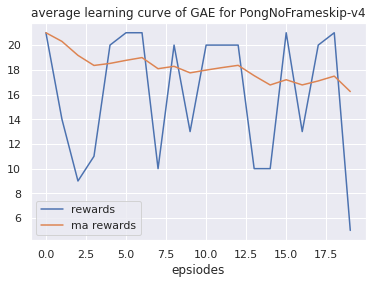

In [12]:
# 0.00014
main()

GAE PongNoFrameskip-v4
Start Training!
20210803-180105
[20210803-180113: GAE] Episode:15: Frame:11359.0: Reward:-21.0: Loss:0.3265
[20210803-180121: GAE] Episode:31: Frame:23548.0: Reward:-21.0: Loss:-0.0449
[20210803-180129: GAE] Episode:47: Frame:35693.0: Reward:-21.0: Loss:-0.0021
[20210803-180136: GAE] Episode:63: Frame:47828.0: Reward:-21.0: Loss:0.0594
[20210803-180143: GAE] Episode:79: Frame:59966.0: Reward:-21.0: Loss:0.1794
[20210803-180149: GAE] Episode:81: Frame:61484.0: Reward:-21.0: Loss:-0.1851
[20210803-180150: GAE] Episode:86: Frame:65394.0: Reward:-21.0: Loss:-0.1447
[20210803-180150: GAE] Episode:90: Frame:68725.0: Reward:-20.0: Loss:-0.1508
[20210803-180151: GAE] Episode:92: Frame:70426.0: Reward:-21.0: Loss:-0.1308
[20210803-180151: GAE] Episode:95: Frame:73076.0: Reward:-20.0: Loss:0.0498
[20210803-180157: GAE] Episode:97: Frame:74796.0: Reward:-21.0: Loss:0.1213
[20210803-180157: GAE] Episode:99: Frame:76464.0: Reward:-20.0: Loss:0.1341
[20210803-180158: GAE] Epis

[20210803-180411: GAE] Episode:376: Frame:302236.0: Reward:-20.0: Loss:-0.0389
[20210803-180411: GAE] Episode:378: Frame:303901.0: Reward:-20.0: Loss:0.1210
[20210803-180412: GAE] Episode:380: Frame:305509.0: Reward:-21.0: Loss:0.2252
[20210803-180413: GAE] Episode:382: Frame:307153.0: Reward:-21.0: Loss:0.0998
[20210803-180417: GAE] Episode:384: Frame:308758.0: Reward:-21.0: Loss:0.1133
[20210803-180418: GAE] Episode:387: Frame:311207.0: Reward:-21.0: Loss:0.0177
[20210803-180419: GAE] Episode:391: Frame:314694.0: Reward:-20.0: Loss:0.2576
[20210803-180420: GAE] Episode:395: Frame:318157.0: Reward:-21.0: Loss:0.0971
[20210803-180421: GAE] Episode:397: Frame:320154.0: Reward:-18.0: Loss:-0.0445
[20210803-180424: GAE] Episode:399: Frame:321985.0: Reward:-20.0: Loss:0.1273
[20210803-180425: GAE] Episode:401: Frame:323618.0: Reward:-20.0: Loss:-0.0064
[20210803-180426: GAE] Episode:403: Frame:325134.0: Reward:-21.0: Loss:0.2003
[20210803-180426: GAE] Episode:405: Frame:326650.0: Reward:-2

[20210803-180616: GAE] Episode:617: Frame:513360.0: Reward:-20.0: Loss:0.0910
[20210803-180617: GAE] Episode:619: Frame:515267.0: Reward:-21.0: Loss:0.1718
[20210803-180619: GAE] Episode:621: Frame:517071.0: Reward:-21.0: Loss:-0.0275
[20210803-180620: GAE] Episode:624: Frame:519543.0: Reward:-21.0: Loss:-0.1463
[20210803-180623: GAE] Episode:626: Frame:521329.0: Reward:-19.0: Loss:-0.1789
[20210803-180623: GAE] Episode:629: Frame:524112.0: Reward:-19.0: Loss:0.0562
[20210803-180624: GAE] Episode:631: Frame:526010.0: Reward:-20.0: Loss:-0.0713
[20210803-180625: GAE] Episode:633: Frame:527825.0: Reward:-20.0: Loss:-0.2668
[20210803-180626: GAE] Episode:635: Frame:529824.0: Reward:-18.0: Loss:-0.0462
[20210803-180629: GAE] Episode:638: Frame:532617.0: Reward:-20.0: Loss:0.2178
[20210803-180631: GAE] Episode:640: Frame:534433.0: Reward:-21.0: Loss:0.0519
[20210803-180631: GAE] Episode:643: Frame:537271.0: Reward:-21.0: Loss:0.2705
[20210803-180632: GAE] Episode:645: Frame:538986.0: Reward

[20210803-180821: GAE] Episode:849: Frame:721691.0: Reward:-20.0: Loss:-0.0060
[20210803-180822: GAE] Episode:851: Frame:723510.0: Reward:-21.0: Loss:0.1117
[20210803-180823: GAE] Episode:853: Frame:725315.0: Reward:-19.0: Loss:0.1804
[20210803-180825: GAE] Episode:855: Frame:727291.0: Reward:-19.0: Loss:0.3109
[20210803-180825: GAE] Episode:858: Frame:729887.0: Reward:-20.0: Loss:-0.0303
[20210803-180827: GAE] Episode:859: Frame:730894.0: Reward:-19.0: Loss:0.1301
[20210803-180827: GAE] Episode:861: Frame:732846.0: Reward:-19.0: Loss:-0.1147
[20210803-180828: GAE] Episode:862: Frame:733987.0: Reward:-17.0: Loss:-0.1946
[20210803-180829: GAE] Episode:864: Frame:735871.0: Reward:-20.0: Loss:-0.1477
[20210803-180831: GAE] Episode:866: Frame:737655.0: Reward:-21.0: Loss:0.0301
[20210803-180831: GAE] Episode:868: Frame:739451.0: Reward:-21.0: Loss:-0.0441
[20210803-180832: GAE] Episode:871: Frame:741993.0: Reward:-21.0: Loss:-0.0150
[20210803-180833: GAE] Episode:873: Frame:743746.0: Rewar

[20210803-181015: GAE] Episode:1043: Frame:913762.0: Reward:-21.0: Loss:-0.1885
[20210803-181015: GAE] Episode:1044: Frame:915025.0: Reward:-18.0: Loss:0.0249
[20210803-181017: GAE] Episode:1047: Frame:918127.0: Reward:-19.0: Loss:0.0956
[20210803-181017: GAE] Episode:1049: Frame:919940.0: Reward:-20.0: Loss:0.0604
[20210803-181019: GAE] Episode:1051: Frame:921702.0: Reward:-20.0: Loss:0.1338
[20210803-181019: GAE] Episode:1053: Frame:923574.0: Reward:-20.0: Loss:0.0939
[20210803-181020: GAE] Episode:1055: Frame:925417.0: Reward:-19.0: Loss:-0.0189
[20210803-181021: GAE] Episode:1057: Frame:926971.0: Reward:-21.0: Loss:0.2952
[20210803-181024: GAE] Episode:1059: Frame:928742.0: Reward:-20.0: Loss:-0.2342
[20210803-181025: GAE] Episode:1061: Frame:930659.0: Reward:-19.0: Loss:-0.1644
[20210803-181027: GAE] Episode:1063: Frame:932558.0: Reward:-20.0: Loss:0.1306
[20210803-181028: GAE] Episode:1064: Frame:933641.0: Reward:-18.0: Loss:-0.1724
[20210803-181028: GAE] Episode:1067: Frame:9364

[20210803-181214: GAE] Episode:1232: Frame:1108795.0: Reward:-20.0: Loss:0.1848
[20210803-181215: GAE] Episode:1233: Frame:1110279.0: Reward:-17.0: Loss:0.0657
[20210803-181215: GAE] Episode:1234: Frame:1111300.0: Reward:-21.0: Loss:0.2618
[20210803-181217: GAE] Episode:1235: Frame:1112715.0: Reward:-16.0: Loss:-0.2262
[20210803-181218: GAE] Episode:1236: Frame:1114163.0: Reward:-19.0: Loss:0.3606
[20210803-181218: GAE] Episode:1238: Frame:1116530.0: Reward:-21.0: Loss:-0.0005
[20210803-181219: GAE] Episode:1240: Frame:1119157.0: Reward:-20.0: Loss:0.0140
[20210803-181220: GAE] Episode:1241: Frame:1120313.0: Reward:-18.0: Loss:-0.0985
[20210803-181221: GAE] Episode:1242: Frame:1121452.0: Reward:-20.0: Loss:-0.0231
[20210803-181221: GAE] Episode:1243: Frame:1122740.0: Reward:-16.0: Loss:0.0111
[20210803-181223: GAE] Episode:1245: Frame:1124899.0: Reward:-20.0: Loss:0.1412
[20210803-181224: GAE] Episode:1247: Frame:1127198.0: Reward:-20.0: Loss:0.1027
[20210803-181225: GAE] Episode:1249:

[20210803-181355: GAE] Episode:1379: Frame:1273584.0: Reward:-19.0: Loss:0.0332
[20210803-181355: GAE] Episode:1381: Frame:1275593.0: Reward:-19.0: Loss:-0.0924
[20210803-181356: GAE] Episode:1383: Frame:1277628.0: Reward:-19.0: Loss:0.1441
[20210803-181357: GAE] Episode:1384: Frame:1278948.0: Reward:-18.0: Loss:0.0694
[20210803-181357: GAE] Episode:1385: Frame:1280063.0: Reward:-20.0: Loss:0.0149
[20210803-181359: GAE] Episode:1388: Frame:1283558.0: Reward:-17.0: Loss:-0.0078
[20210803-181403: GAE] Episode:1389: Frame:1285092.0: Reward:-17.0: Loss:0.3293
[20210803-181403: GAE] Episode:1390: Frame:1286501.0: Reward:-19.0: Loss:0.3282
[20210803-181403: GAE] Episode:1391: Frame:1287821.0: Reward:-21.0: Loss:-0.0820
[20210803-181405: GAE] Episode:1392: Frame:1289053.0: Reward:-19.0: Loss:-0.0208
[20210803-181406: GAE] Episode:1393: Frame:1290111.0: Reward:-21.0: Loss:0.0348
[20210803-181407: GAE] Episode:1395: Frame:1292562.0: Reward:-17.0: Loss:0.1170
[20210803-181407: GAE] Episode:1398:

[20210803-181559: GAE] Episode:1521: Frame:1479036.0: Reward:-18.0: Loss:0.0346
[20210803-181600: GAE] Episode:1522: Frame:1480669.0: Reward:-18.0: Loss:-0.0810
[20210803-181601: GAE] Episode:1523: Frame:1482294.0: Reward:-19.0: Loss:0.0259
[20210803-181601: GAE] Episode:1524: Frame:1483924.0: Reward:-17.0: Loss:0.0327
[20210803-181602: GAE] Episode:1526: Frame:1486337.0: Reward:-21.0: Loss:0.0142
[20210803-181602: GAE] Episode:1527: Frame:1487609.0: Reward:-21.0: Loss:0.0202
[20210803-181602: GAE] Episode:1528: Frame:1489109.0: Reward:-19.0: Loss:0.0223
[20210803-181604: GAE] Episode:1530: Frame:1491321.0: Reward:-20.0: Loss:0.0315
[20210803-181604: GAE] Episode:1532: Frame:1493502.0: Reward:-21.0: Loss:0.0362
[20210803-181605: GAE] Episode:1534: Frame:1495511.0: Reward:-19.0: Loss:0.0478
[20210803-181605: GAE] Episode:1535: Frame:1496512.0: Reward:-21.0: Loss:0.0465
[20210803-181607: GAE] Episode:1537: Frame:1498208.0: Reward:-21.0: Loss:-0.0288
[20210803-181608: GAE] Episode:1539: F

[20210803-181756: GAE] Episode:1649: Frame:1674935.0: Reward:-13.0: Loss:0.0706
[20210803-181756: GAE] Episode:1650: Frame:1677205.0: Reward:-12.0: Loss:0.0273
[20210803-181758: GAE] Episode:1651: Frame:1679312.0: Reward:-11.0: Loss:-0.0059
[20210803-181759: GAE] Episode:1652: Frame:1681260.0: Reward:-14.0: Loss:0.0238
[20210803-181800: GAE] Episode:1653: Frame:1683308.0: Reward:-13.0: Loss:0.0479
[20210803-181802: GAE] Episode:1654: Frame:1685175.0: Reward:-17.0: Loss:-0.0515
[20210803-181804: GAE] Episode:1656: Frame:1688963.0: Reward:-14.0: Loss:0.0850
[20210803-181807: GAE] Episode:1658: Frame:1692728.0: Reward:-18.0: Loss:0.2305
[20210803-181808: GAE] Episode:1659: Frame:1694823.0: Reward:-15.0: Loss:0.2134
[20210803-181809: GAE] Episode:1660: Frame:1696376.0: Reward:-20.0: Loss:-0.1140
[20210803-181811: GAE] Episode:1661: Frame:1698421.0: Reward:-17.0: Loss:0.0516
[20210803-181813: GAE] Episode:1662: Frame:1700652.0: Reward:-15.0: Loss:0.0079
[20210803-181814: GAE] Episode:1664: 

[20210803-182029: GAE] Episode:1767: Frame:1936769.0: Reward:-10.0: Loss:0.0804
[20210803-182031: GAE] Episode:1768: Frame:1939030.0: Reward:-12.0: Loss:-0.0368
[20210803-182032: GAE] Episode:1769: Frame:1941474.0: Reward:-8.0: Loss:0.0413
[20210803-182032: GAE] Episode:1770: Frame:1943314.0: Reward:14.0: Loss:0.0582
[20210803-182035: GAE] Episode:1771: Frame:1945797.0: Reward:-10.0: Loss:0.0529
[20210803-182037: GAE] Episode:1772: Frame:1947419.0: Reward:19.0: Loss:-0.0639
[20210803-182039: GAE] Episode:1773: Frame:1949501.0: Reward:-15.0: Loss:0.0259
[20210803-182040: GAE] Episode:1774: Frame:1951279.0: Reward:17.0: Loss:0.0356
[20210803-182045: GAE] Episode:1776: Frame:1955838.0: Reward:15.0: Loss:0.0456
[20210803-182045: GAE] Episode:1777: Frame:1958192.0: Reward:-13.0: Loss:0.1074
[20210803-182046: GAE] Episode:1778: Frame:1960573.0: Reward:13.0: Loss:0.0105
[20210803-182046: GAE] Episode:1779: Frame:1962930.0: Reward:-8.0: Loss:-0.0604
[20210803-182049: GAE] Episode:1780: Frame:1

[20210803-182307: GAE] Episode:1890: Frame:2202984.0: Reward:20.0: Loss:-0.0308
[20210803-182309: GAE] Episode:1891: Frame:2204611.0: Reward:19.0: Loss:0.0201
[20210803-182310: GAE] Episode:1892: Frame:2207466.0: Reward:-7.0: Loss:0.0558
[20210803-182311: GAE] Episode:1893: Frame:2209057.0: Reward:20.0: Loss:-0.0027
[20210803-182314: GAE] Episode:1894: Frame:2210684.0: Reward:19.0: Loss:0.0043
[20210803-182315: GAE] Episode:1896: Frame:2213833.0: Reward:20.0: Loss:0.0044
[20210803-182317: GAE] Episode:1897: Frame:2215423.0: Reward:20.0: Loss:0.0014
[20210803-182318: GAE] Episode:1898: Frame:2217441.0: Reward:13.0: Loss:0.0125
[20210803-182319: GAE] Episode:1899: Frame:2220338.0: Reward:-1.0: Loss:0.0142
[20210803-182320: GAE] Episode:1900: Frame:2221927.0: Reward:20.0: Loss:0.0052
[20210803-182321: GAE] Episode:1901: Frame:2224752.0: Reward:-2.0: Loss:0.0022
[20210803-182321: GAE] Episode:1902: Frame:2226408.0: Reward:19.0: Loss:0.0021
[20210803-182324: GAE] Episode:1903: Frame:2228064

[20210803-182543: GAE] Episode:2010: Frame:2469120.0: Reward:-3.0: Loss:0.0188
[20210803-182546: GAE] Episode:2011: Frame:2470892.0: Reward:19.0: Loss:-0.0065
[20210803-182547: GAE] Episode:2012: Frame:2472526.0: Reward:19.0: Loss:-0.0940
[20210803-182547: GAE] Episode:2013: Frame:2474271.0: Reward:19.0: Loss:0.0966
[20210803-182548: GAE] Episode:2014: Frame:2477191.0: Reward:-5.0: Loss:-0.0517
[20210803-182548: GAE] Episode:2015: Frame:2479776.0: Reward:5.0: Loss:0.0819
[20210803-182551: GAE] Episode:2016: Frame:2481397.0: Reward:20.0: Loss:0.0228
[20210803-182552: GAE] Episode:2017: Frame:2483393.0: Reward:17.0: Loss:-0.0226
[20210803-182553: GAE] Episode:2018: Frame:2485147.0: Reward:19.0: Loss:0.0464
[20210803-182554: GAE] Episode:2019: Frame:2486734.0: Reward:20.0: Loss:0.0460
[20210803-182555: GAE] Episode:2020: Frame:2489937.0: Reward:-2.0: Loss:0.0288
[20210803-182556: GAE] Episode:2021: Frame:2491877.0: Reward:16.0: Loss:0.0038
[20210803-182559: GAE] Episode:2022: Frame:249464

[20210803-182810: GAE] Episode:2123: Frame:2721021.0: Reward:19.0: Loss:-0.0146
[20210803-182810: GAE] Episode:2124: Frame:2723217.0: Reward:17.0: Loss:-0.0325
[20210803-182812: GAE] Episode:2125: Frame:2725748.0: Reward:12.0: Loss:0.0024
[20210803-182813: GAE] Episode:2126: Frame:2728228.0: Reward:14.0: Loss:0.0317
[20210803-182813: GAE] Episode:2127: Frame:2731033.0: Reward:9.0: Loss:0.0046
[20210803-182814: GAE] Episode:2129: Frame:2734781.0: Reward:20.0: Loss:-0.0014
[20210803-182815: GAE] Episode:2130: Frame:2737473.0: Reward:14.0: Loss:0.0340
[20210803-182816: GAE] Episode:2132: Frame:2742188.0: Reward:15.0: Loss:0.0156
[20210803-182817: GAE] Episode:2133: Frame:2744290.0: Reward:19.0: Loss:0.0144
[20210803-182819: GAE] Episode:2134: Frame:2746462.0: Reward:19.0: Loss:-0.0199
[20210803-182820: GAE] Episode:2135: Frame:2748550.0: Reward:20.0: Loss:-0.0521
[20210803-182821: GAE] Episode:2136: Frame:2751050.0: Reward:15.0: Loss:0.0496
[20210803-182823: GAE] Episode:2137: Frame:27532

[20210803-183022: GAE] Episode:2244: Frame:2960219.0: Reward:18.0: Loss:-0.0405
[20210803-183025: GAE] Episode:2245: Frame:2961846.0: Reward:19.0: Loss:-0.0023
[20210803-183025: GAE] Episode:2247: Frame:2965107.0: Reward:19.0: Loss:0.0216
[20210803-183026: GAE] Episode:2248: Frame:2967382.0: Reward:14.0: Loss:0.0092
[20210803-183027: GAE] Episode:2249: Frame:2969351.0: Reward:21.0: Loss:0.0290
[20210803-183028: GAE] Episode:2250: Frame:2971487.0: Reward:15.0: Loss:-0.0353
[20210803-183029: GAE] Episode:2251: Frame:2973486.0: Reward:20.0: Loss:-0.0108
[20210803-183031: GAE] Episode:2252: Frame:2975489.0: Reward:20.0: Loss:-0.0061
[20210803-183032: GAE] Episode:2253: Frame:2977119.0: Reward:19.0: Loss:0.0112
[20210803-183033: GAE] Episode:2254: Frame:2978683.0: Reward:20.0: Loss:-0.0108
[20210803-183033: GAE] Episode:2255: Frame:2980265.0: Reward:20.0: Loss:0.0046
[20210803-183036: GAE] Episode:2256: Frame:2982269.0: Reward:20.0: Loss:0.0111
[20210803-183037: GAE] Episode:2258: Frame:298

[20210803-183244: GAE] Episode:2369: Frame:3200452.0: Reward:21.0: Loss:-0.0441
[20210803-183245: GAE] Episode:2371: Frame:3204244.0: Reward:18.0: Loss:-0.0783
[20210803-183245: GAE] Episode:2372: Frame:3206501.0: Reward:18.0: Loss:0.0010
[20210803-183246: GAE] Episode:2373: Frame:3208471.0: Reward:21.0: Loss:-0.0447
[20210803-183248: GAE] Episode:2375: Frame:3212057.0: Reward:20.0: Loss:0.0120
[20210803-183248: GAE] Episode:2376: Frame:3214028.0: Reward:21.0: Loss:0.0772
[20210803-183250: GAE] Episode:2378: Frame:3217597.0: Reward:20.0: Loss:-0.0057
[20210803-183250: GAE] Episode:2379: Frame:3219734.0: Reward:19.0: Loss:0.0529
[20210803-183256: GAE] Episode:2380: Frame:3221838.0: Reward:18.0: Loss:-0.0088
[20210803-183256: GAE] Episode:2381: Frame:3223840.0: Reward:20.0: Loss:-0.0024
[20210803-183258: GAE] Episode:2382: Frame:3226390.0: Reward:11.0: Loss:0.0265
[20210803-183258: GAE] Episode:2383: Frame:3228299.0: Reward:18.0: Loss:0.0091
[20210803-183301: GAE] Episode:2385: Frame:323

[20210803-183456: GAE] Episode:2489: Frame:3424431.0: Reward:15.0: Loss:-0.0798
[20210803-183457: GAE] Episode:2490: Frame:3426457.0: Reward:20.0: Loss:-0.0824
[20210803-183458: GAE] Episode:2491: Frame:3428053.0: Reward:20.0: Loss:-0.0058
[20210803-183458: GAE] Episode:2492: Frame:3430604.0: Reward:11.0: Loss:-0.0399
[20210803-183459: GAE] Episode:2493: Frame:3432634.0: Reward:20.0: Loss:0.0114
[20210803-183459: GAE] Episode:2494: Frame:3434809.0: Reward:17.0: Loss:-0.0348
[20210803-183504: GAE] Episode:2495: Frame:3437523.0: Reward:13.0: Loss:-0.0197
[20210803-183506: GAE] Episode:2496: Frame:3439857.0: Reward:18.0: Loss:0.0222
[20210803-183510: GAE] Episode:2497: Frame:3442216.0: Reward:16.0: Loss:0.0305
[20210803-183511: GAE] Episode:2499: Frame:3445749.0: Reward:21.0: Loss:0.0228
[20210803-183511: GAE] Episode:2500: Frame:3447922.0: Reward:18.0: Loss:0.0197
[20210803-183512: GAE] Episode:2502: Frame:3452368.0: Reward:17.0: Loss:-0.0282
[20210803-183513: GAE] Episode:2504: Frame:34

[20210803-183710: GAE] Episode:2611: Frame:3653153.0: Reward:19.0: Loss:-0.0167
[20210803-183711: GAE] Episode:2612: Frame:3654745.0: Reward:20.0: Loss:0.0046
[20210803-183713: GAE] Episode:2614: Frame:3658312.0: Reward:20.0: Loss:-0.0198
[20210803-183714: GAE] Episode:2615: Frame:3659911.0: Reward:20.0: Loss:0.0086
[20210803-183715: GAE] Episode:2616: Frame:3661882.0: Reward:21.0: Loss:-0.0015
[20210803-183716: GAE] Episode:2617: Frame:3663475.0: Reward:20.0: Loss:0.0342
[20210803-183718: GAE] Episode:2618: Frame:3665628.0: Reward:19.0: Loss:0.0289
[20210803-183719: GAE] Episode:2620: Frame:3668780.0: Reward:20.0: Loss:-0.0014
[20210803-183719: GAE] Episode:2621: Frame:3670376.0: Reward:20.0: Loss:0.0073
[20210803-183721: GAE] Episode:2622: Frame:3672409.0: Reward:20.0: Loss:-0.0039
[20210803-183724: GAE] Episode:2623: Frame:3674004.0: Reward:20.0: Loss:0.0178
[20210803-183725: GAE] Episode:2624: Frame:3675591.0: Reward:20.0: Loss:-0.0267
[20210803-183726: GAE] Episode:2625: Frame:367

[20210803-183929: GAE] Episode:2738: Frame:3888905.0: Reward:20.0: Loss:-0.0256
[20210803-183930: GAE] Episode:2739: Frame:3890495.0: Reward:20.0: Loss:0.0517
[20210803-183930: GAE] Episode:2740: Frame:3892092.0: Reward:20.0: Loss:0.0248
[20210803-183934: GAE] Episode:2742: Frame:3896349.0: Reward:17.0: Loss:-0.0422
[20210803-183936: GAE] Episode:2744: Frame:3899501.0: Reward:20.0: Loss:-0.0082
[20210803-183936: GAE] Episode:2745: Frame:3901473.0: Reward:21.0: Loss:-0.0080
[20210803-183938: GAE] Episode:2746: Frame:3903444.0: Reward:21.0: Loss:0.0228
[20210803-183939: GAE] Episode:2747: Frame:3905413.0: Reward:21.0: Loss:0.0118
[20210803-183942: GAE] Episode:2748: Frame:3907382.0: Reward:21.0: Loss:0.0092
[20210803-183942: GAE] Episode:2749: Frame:3909354.0: Reward:21.0: Loss:-0.0304
[20210803-183944: GAE] Episode:2751: Frame:3913462.0: Reward:17.0: Loss:0.0240
[20210803-183944: GAE] Episode:2752: Frame:3915329.0: Reward:18.0: Loss:-0.0037
[20210803-183945: GAE] Episode:2753: Frame:391

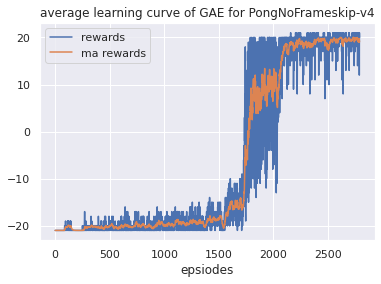

Start Evaluating!
20210803-184029
[20210803-184036: GAE] Episode:1: Frame:1598.0: Reward:20.0
[20210803-184038: GAE] Episode:2: Frame:3570.0: Reward:21.0
[20210803-184038: GAE] Episode:3: Frame:5568.0: Reward:20.0
[20210803-184038: GAE] Episode:4: Frame:7594.0: Reward:20.0
[20210803-184044: GAE] Episode:5: Frame:9395.0: Reward:19.0
[20210803-184046: GAE] Episode:6: Frame:11260.0: Reward:18.0
[20210803-184046: GAE] Episode:7: Frame:13229.0: Reward:21.0
[20210803-184047: GAE] Episode:8: Frame:15252.0: Reward:17.0
[20210803-184054: GAE] Episode:9: Frame:17283.0: Reward:20.0
[20210803-184054: GAE] Episode:10: Frame:18881.0: Reward:20.0
[20210803-184055: GAE] Episode:11: Frame:20471.0: Reward:20.0
[20210803-184057: GAE] Episode:12: Frame:22501.0: Reward:20.0
[20210803-184102: GAE] Episode:13: Frame:24091.0: Reward:20.0
[20210803-184104: GAE] Episode:14: Frame:26063.0: Reward:21.0
[20210803-184107: GAE] Episode:15: Frame:28037.0: Reward:21.0
[20210803-184108: GAE] Episode:16: Frame:30469.0: 

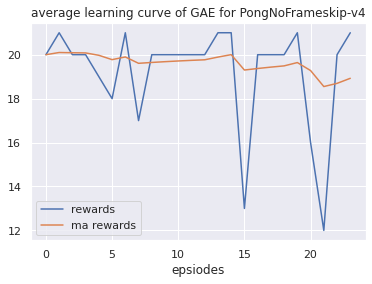

In [14]:
#0.00012
main()

## LunarLanderContinuous-v2

In [7]:
class config:
    def __init__(self):
        self.seed = 1                         # seed
        self.agent = 'GAE'             # name of agent
        self.env_id = 'LunarLanderContinuous-v2'    # name of environment
        self.result_path = curr_path+"/outputs/" +self.env_id+'/'+curr_time+'/'+self.agent+'/results/'  # path to save results
        self.model_path = curr_path+"/outputs/" +self.env_id+'/'+curr_time+'/'+self.agent+'/models/'  # path to save models
        self.n_train_env = 16           # number of training environment 
        self.n_eval_env = 4           # number of evaluation environment 
        self.max_train_frames = 4.5e6     # max number of training frames
        self.max_eval_frames = 6e4      # max number of evaluation frames
        self.w_critic_loss = 0.25         # weight of critic loss
        self.w_entropy_loss = 0.001      # weight of entropy loss
        self.lr = 0.002                 # learning rate
        self.gamma = 0.998              # discount rate of reward
        self.tau = 0.998                # discount rate of Advantage function
        self.n_multi_step = 1000          # number of steps of multi-step style gain 
        self.model = 'Continuous_MLP'             # name of model
        self.hidden_dim = 256           # dimmension of hidden layer
        self.max_act = 1.0              # max value of action
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # check gpu

GAE LunarLanderContinuous-v2
Start Training!
20210729-151012
[20210729-151016: GAE] Episode:152: Frame:15177.0: Reward:-20.0
[20210729-151022: GAE] Episode:323: Frame:31131.0: Reward:-75.1: Loss:6349.2695
[20210729-151027: GAE] Episode:527: Frame:47298.0: Reward:-108.3: Loss:5101.9780
[20210729-151032: GAE] Episode:734: Frame:63301.0: Reward:-153.0: Loss:2702.0391
[20210729-151037: GAE] Episode:956: Frame:79442.0: Reward:-95.2: Loss:2574.0344
[20210729-151042: GAE] Episode:1173: Frame:95330.0: Reward:-125.3: Loss:2014.1100
[20210729-151047: GAE] Episode:1390: Frame:111509.0: Reward:-21.8: Loss:2078.0481
[20210729-151052: GAE] Episode:1608: Frame:127486.0: Reward:-150.8: Loss:2138.3013
[20210729-151057: GAE] Episode:1827: Frame:143447.0: Reward:-134.8: Loss:1835.6403
[20210729-151103: GAE] Episode:2049: Frame:159404.0: Reward:-102.5: Loss:1735.5044
[20210729-151108: GAE] Episode:2272: Frame:175213.0: Reward:-133.5: Loss:1700.5355
[20210729-151113: GAE] Episode:2496: Frame:191521.0: Rewa

[20210729-152444: GAE] Episode:7471: Frame:1625801.0: Reward:-189.1: Loss:300.9491
[20210729-152453: GAE] Episode:7513: Frame:1643338.0: Reward:32.3: Loss:309.1462
[20210729-152501: GAE] Episode:7553: Frame:1659577.0: Reward:65.1: Loss:388.1937
[20210729-152510: GAE] Episode:7600: Frame:1673552.0: Reward:24.1: Loss:368.0080
[20210729-152519: GAE] Episode:7643: Frame:1690877.0: Reward:28.2: Loss:414.1777
[20210729-152527: GAE] Episode:7682: Frame:1707578.0: Reward:65.3: Loss:455.6655
[20210729-152535: GAE] Episode:7743: Frame:1724859.0: Reward:50.2: Loss:376.4591
[20210729-152543: GAE] Episode:7776: Frame:1736480.0: Reward:57.8: Loss:377.5917
[20210729-152551: GAE] Episode:7799: Frame:1751881.0: Reward:-1.5: Loss:411.9332
[20210729-152601: GAE] Episode:7820: Frame:1767158.0: Reward:47.3: Loss:348.6400
[20210729-152609: GAE] Episode:7838: Frame:1783445.0: Reward:121.5: Loss:351.5219
[20210729-152618: GAE] Episode:7860: Frame:1799822.0: Reward:107.1: Loss:239.5634
[20210729-152628: GAE] E

[20210729-153734: GAE] Episode:9532: Frame:3242358.0: Reward:58.7: Loss:1124.6035
[20210729-153742: GAE] Episode:9549: Frame:3256838.0: Reward:116.0: Loss:342.5453
[20210729-153748: GAE] Episode:9568: Frame:3271390.0: Reward:155.9: Loss:672.9639
[20210729-153755: GAE] Episode:9588: Frame:3287730.0: Reward:102.4: Loss:336.9505
[20210729-153803: GAE] Episode:9608: Frame:3305022.0: Reward:-7.9: Loss:1000.8326
[20210729-153810: GAE] Episode:9627: Frame:3321638.0: Reward:84.3: Loss:250.4069
[20210729-153818: GAE] Episode:9645: Frame:3337919.0: Reward:-62.4: Loss:529.6601
[20210729-153827: GAE] Episode:9664: Frame:3355009.0: Reward:-13.2: Loss:380.0295
[20210729-153834: GAE] Episode:9682: Frame:3370847.0: Reward:88.1: Loss:182.4343
[20210729-153842: GAE] Episode:9698: Frame:3386237.0: Reward:92.3: Loss:457.2037
[20210729-153849: GAE] Episode:9716: Frame:3403316.0: Reward:181.0: Loss:312.2751
[20210729-153857: GAE] Episode:9732: Frame:3419316.0: Reward:137.8: Loss:205.4954
[20210729-153905: G

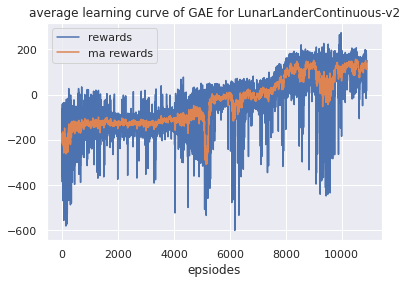

Start Evaluating!
20210729-154729
[20210729-154730: GAE] Episode:1: Frame:169.0: Reward:35.3
[20210729-154730: GAE] Episode:2: Frame:360.0: Reward:15.5
[20210729-154733: GAE] Episode:5: Frame:3360.0: Reward:176.3
[20210729-154734: GAE] Episode:6: Frame:3525.0: Reward:11.8
[20210729-154735: GAE] Episode:7: Frame:4525.0: Reward:163.1
[20210729-154736: GAE] Episode:8: Frame:4718.0: Reward:35.3
[20210729-154738: GAE] Episode:10: Frame:6718.0: Reward:145.1
[20210729-154738: GAE] Episode:11: Frame:7718.0: Reward:166.3
[20210729-154740: GAE] Episode:12: Frame:8718.0: Reward:185.9
[20210729-154742: GAE] Episode:14: Frame:10718.0: Reward:146.1
[20210729-154743: GAE] Episode:15: Frame:11718.0: Reward:187.6
[20210729-154745: GAE] Episode:16: Frame:12718.0: Reward:131.5
[20210729-154747: GAE] Episode:18: Frame:14718.0: Reward:148.0
[20210729-154747: GAE] Episode:19: Frame:14871.0: Reward:28.9
[20210729-154748: GAE] Episode:20: Frame:15871.0: Reward:63.6
[20210729-154749: GAE] Episode:21: Frame:168

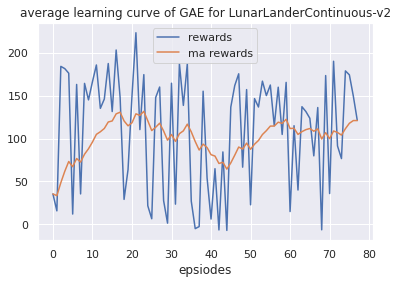

In [8]:
# 0.002, 0.998, 0.998, 1000
main()

## Pendulum-v0

In [24]:
class config:
    def __init__(self):
        self.seed = 1                         # seed
        self.agent = 'GAE'             # name of agent
        self.env_id = 'Pendulum-v0'    # name of environment
        self.result_path = curr_path+"/outputs/" +self.env_id+'/'+curr_time+'/'+self.agent+'/results/'  # path to save results
        self.model_path = curr_path+"/outputs/" +self.env_id+'/'+curr_time+'/'+self.agent+'/models/'  # path to save models
        self.n_train_env = 16           # number of training environment 
        self.n_eval_env = 4           # number of evaluation environment 
        self.max_train_frames = 1.5e6     # max number of training frames
        self.max_eval_frames = 1e4      # max number of evaluation frames
        self.w_critic_loss = 0.25         # weight of critic loss
        self.w_entropy_loss = 0.001      # weight of entropy loss
        self.lr = 0.0002                 # learning rate
        self.gamma = 0.95              # discount rate of reward
        self.tau = 0.95                 # discount rate of Advantage function
        self.n_multi_step = 16          # number of steps of multi-step style gain 
        self.model = 'Continuous_MLP'             # name of model
        self.hidden_dim = 256           # dimmension of hidden layer
        self.max_act = 2.0
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # check gpu

GAE Pendulum-v0
Start Training!
20210729-175754
[20210729-175755: GAE] Episode:16: Frame:3200.0: Reward:-1821.9: Loss:344.7013
[20210729-175757: GAE] Episode:32: Frame:6400.0: Reward:-1454.6: Loss:515.0510
[20210729-175758: GAE] Episode:48: Frame:9600.0: Reward:-1408.8: Loss:603.1193
[20210729-175759: GAE] Episode:64: Frame:12800.0: Reward:-1625.9: Loss:515.4509
[20210729-175801: GAE] Episode:80: Frame:16000.0: Reward:-1650.2: Loss:511.0238
[20210729-175802: GAE] Episode:96: Frame:19200.0: Reward:-1685.8: Loss:393.6713
[20210729-175804: GAE] Episode:112: Frame:22400.0: Reward:-1680.5: Loss:363.6199
[20210729-175805: GAE] Episode:128: Frame:25600.0: Reward:-1597.4: Loss:284.7925
[20210729-175806: GAE] Episode:144: Frame:28800.0: Reward:-1727.7: Loss:298.1054
[20210729-175808: GAE] Episode:160: Frame:32000.0: Reward:-1551.1: Loss:222.8053
[20210729-175809: GAE] Episode:176: Frame:35200.0: Reward:-1741.6: Loss:220.3030
[20210729-175810: GAE] Episode:192: Frame:38400.0: Reward:-1783.6: Los

[20210729-180012: GAE] Episode:1632: Frame:326400.0: Reward:-1121.3: Loss:37.4771
[20210729-180013: GAE] Episode:1648: Frame:329600.0: Reward:-886.8: Loss:26.1238
[20210729-180014: GAE] Episode:1664: Frame:332800.0: Reward:-977.7: Loss:25.5344
[20210729-180015: GAE] Episode:1680: Frame:336000.0: Reward:-1261.3: Loss:28.9715
[20210729-180016: GAE] Episode:1696: Frame:339200.0: Reward:-1018.3: Loss:23.0578
[20210729-180017: GAE] Episode:1712: Frame:342400.0: Reward:-988.0: Loss:46.5975
[20210729-180018: GAE] Episode:1728: Frame:345600.0: Reward:-933.1: Loss:28.2905
[20210729-180019: GAE] Episode:1744: Frame:348800.0: Reward:-914.8: Loss:34.9415
[20210729-180020: GAE] Episode:1760: Frame:352000.0: Reward:-758.1: Loss:17.8437
[20210729-180021: GAE] Episode:1776: Frame:355200.0: Reward:-528.2: Loss:33.2014
[20210729-180022: GAE] Episode:1792: Frame:358400.0: Reward:-654.4: Loss:20.2960
[20210729-180023: GAE] Episode:1808: Frame:361600.0: Reward:-759.4: Loss:23.3330
[20210729-180025: GAE] Ep

[20210729-180228: GAE] Episode:3248: Frame:649600.0: Reward:-895.0: Loss:12.3067
[20210729-180229: GAE] Episode:3264: Frame:652800.0: Reward:-510.5: Loss:7.8600
[20210729-180230: GAE] Episode:3280: Frame:656000.0: Reward:-641.4: Loss:4.0764
[20210729-180231: GAE] Episode:3296: Frame:659200.0: Reward:-976.0: Loss:10.4703
[20210729-180232: GAE] Episode:3312: Frame:662400.0: Reward:-530.0: Loss:15.3353
[20210729-180232: GAE] Episode:3328: Frame:665600.0: Reward:-771.3: Loss:9.4353
[20210729-180233: GAE] Episode:3344: Frame:668800.0: Reward:-262.4: Loss:14.0616
[20210729-180234: GAE] Episode:3360: Frame:672000.0: Reward:-1019.4: Loss:10.7924
[20210729-180235: GAE] Episode:3376: Frame:675200.0: Reward:-382.4: Loss:4.1473
[20210729-180237: GAE] Episode:3392: Frame:678400.0: Reward:-522.8: Loss:5.2388
[20210729-180238: GAE] Episode:3408: Frame:681600.0: Reward:-554.6: Loss:4.0078
[20210729-180240: GAE] Episode:3424: Frame:684800.0: Reward:-672.5: Loss:5.2776
[20210729-180241: GAE] Episode:344

[20210729-180446: GAE] Episode:4896: Frame:979200.0: Reward:-1028.1: Loss:19.7258
[20210729-180447: GAE] Episode:4912: Frame:982400.0: Reward:-798.1: Loss:3.8253
[20210729-180449: GAE] Episode:4928: Frame:985600.0: Reward:-513.8: Loss:1.5281
[20210729-180451: GAE] Episode:4944: Frame:988800.0: Reward:-132.1: Loss:7.0750
[20210729-180453: GAE] Episode:4960: Frame:992000.0: Reward:-778.4: Loss:4.7250
[20210729-180454: GAE] Episode:4976: Frame:995200.0: Reward:-128.3: Loss:0.4483
[20210729-180456: GAE] Episode:4992: Frame:998400.0: Reward:-499.2: Loss:-0.1394
[20210729-180458: GAE] Episode:5008: Frame:1001600.0: Reward:-259.4: Loss:-0.0728
[20210729-180459: GAE] Episode:5024: Frame:1004800.0: Reward:-130.6: Loss:2.3277
[20210729-180501: GAE] Episode:5040: Frame:1008000.0: Reward:-759.9: Loss:2.1963
[20210729-180503: GAE] Episode:5056: Frame:1011200.0: Reward:-524.8: Loss:2.5954
[20210729-180505: GAE] Episode:5072: Frame:1014400.0: Reward:-871.1: Loss:2.7927
[20210729-180506: GAE] Episode:

[20210729-180701: GAE] Episode:6528: Frame:1305600.0: Reward:-129.0: Loss:2.5292
[20210729-180702: GAE] Episode:6544: Frame:1308800.0: Reward:-1155.2: Loss:0.3250
[20210729-180704: GAE] Episode:6560: Frame:1312000.0: Reward:-570.1: Loss:0.8970
[20210729-180705: GAE] Episode:6576: Frame:1315200.0: Reward:-2.1: Loss:0.0733
[20210729-180707: GAE] Episode:6592: Frame:1318400.0: Reward:-127.8: Loss:11.6328
[20210729-180708: GAE] Episode:6608: Frame:1321600.0: Reward:-512.3: Loss:3.6704
[20210729-180709: GAE] Episode:6624: Frame:1324800.0: Reward:-2.1: Loss:1.4984
[20210729-180711: GAE] Episode:6640: Frame:1328000.0: Reward:-511.8: Loss:2.0111
[20210729-180712: GAE] Episode:6656: Frame:1331200.0: Reward:-765.4: Loss:2.9041
[20210729-180713: GAE] Episode:6672: Frame:1334400.0: Reward:-636.5: Loss:0.0238
[20210729-180715: GAE] Episode:6688: Frame:1337600.0: Reward:-2.9: Loss:0.8690
[20210729-180716: GAE] Episode:6704: Frame:1340800.0: Reward:-558.6: Loss:-0.0632
[20210729-180717: GAE] Episode:

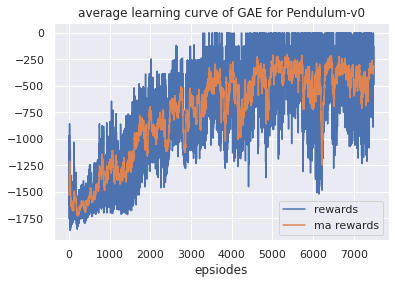

Start Evaluating!
20210729-180823
[20210729-180823: GAE] Episode:4: Frame:800.0: Reward:-251.1
[20210729-180824: GAE] Episode:8: Frame:1600.0: Reward:-128.3
[20210729-180824: GAE] Episode:12: Frame:2400.0: Reward:-128.2
[20210729-180824: GAE] Episode:16: Frame:3200.0: Reward:-254.9
[20210729-180825: GAE] Episode:20: Frame:4000.0: Reward:-260.4
[20210729-180825: GAE] Episode:24: Frame:4800.0: Reward:-125.2
[20210729-180825: GAE] Episode:28: Frame:5600.0: Reward:-371.6
[20210729-180826: GAE] Episode:32: Frame:6400.0: Reward:-2.6
[20210729-180826: GAE] Episode:36: Frame:7200.0: Reward:-130.3
[20210729-180827: GAE] Episode:40: Frame:8000.0: Reward:-2.8
[20210729-180827: GAE] Episode:44: Frame:8800.0: Reward:-129.1
[20210729-180827: GAE] Episode:48: Frame:9600.0: Reward:-441.7
results saved!


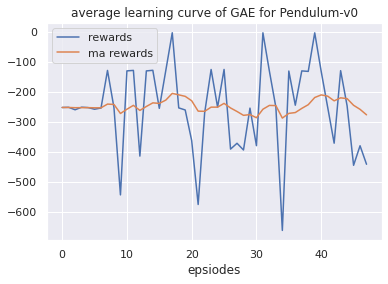

In [25]:
main()

## CartPole-v0

In [31]:
class config:
    def __init__(self):
        self.seed = 1                         # seed
        self.agent = 'GAE'             # name of agent
        self.env_id = 'CartPole-v0'    # name of environment
        self.result_path = curr_path+"/outputs/" +self.env_id+'/'+curr_time+'/'+self.agent+'/results/'  # path to save results
        self.model_path = curr_path+"/outputs/" +self.env_id+'/'+curr_time+'/'+self.agent+'/models/'  # path to save models
        self.n_train_env = 16           # number of training environment 
        self.n_eval_env = 4           # number of evaluation environment 
        self.max_train_frames = 3.4e5     # max number of training frames
        self.max_eval_frames = 1e4      # max number of evaluation frames
        self.w_critic_loss = 0.25         # weight of critic loss
        self.w_entropy_loss = 0.001      # weight of entropy loss
        self.lr = 0.0002                 # learning rate
        self.gamma = 0.99              # discount rate of reward
        self.tau = 0.98                # discount rate of Advantage function
        self.n_multi_step = 6          # number of steps of multi-step style gain 
        self.model = 'Discrete_MLP'             # name of model
        self.hidden_dim = 256           # dimmension of hidden layer
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # check gpu

GAE CartPole-v0
Start Training!
20210804-140340
[20210804-140340: GAE] Episode:5: Frame:53.0: Reward:12.0: Loss:5.8284
[20210804-140341: GAE] Episode:61: Frame:1093.0: Reward:35.0: Loss:4.0531
[20210804-140342: GAE] Episode:112: Frame:2217.0: Reward:18.0: Loss:3.3878
[20210804-140342: GAE] Episode:163: Frame:3301.0: Reward:11.0: Loss:2.5379
[20210804-140343: GAE] Episode:212: Frame:4305.0: Reward:15.0: Loss:2.3223
[20210804-140343: GAE] Episode:270: Frame:5526.0: Reward:23.0: Loss:1.9543
[20210804-140344: GAE] Episode:322: Frame:6600.0: Reward:18.0: Loss:1.5727
[20210804-140345: GAE] Episode:388: Frame:7638.0: Reward:9.0: Loss:1.4703
[20210804-140345: GAE] Episode:450: Frame:8699.0: Reward:12.0: Loss:1.4088
[20210804-140346: GAE] Episode:509: Frame:9735.0: Reward:17.0: Loss:1.1481
[20210804-140346: GAE] Episode:566: Frame:10788.0: Reward:11.0: Loss:0.9890
[20210804-140347: GAE] Episode:618: Frame:11837.0: Reward:18.0: Loss:1.1923
[20210804-140348: GAE] Episode:669: Frame:12882.0: Rewar

[20210804-140424: GAE] Episode:1711: Frame:118499.0: Reward:200.0: Loss:0.6108
[20210804-140424: GAE] Episode:1717: Frame:119689.0: Reward:200.0: Loss:0.5458
[20210804-140425: GAE] Episode:1722: Frame:120689.0: Reward:200.0: Loss:0.6144
[20210804-140425: GAE] Episode:1728: Frame:121774.0: Reward:193.0: Loss:0.6972
[20210804-140425: GAE] Episode:1735: Frame:122858.0: Reward:139.0: Loss:0.5924
[20210804-140425: GAE] Episode:1743: Frame:124003.0: Reward:155.0: Loss:0.6930
[20210804-140426: GAE] Episode:1750: Frame:125047.0: Reward:143.0: Loss:0.3791
[20210804-140426: GAE] Episode:1758: Frame:126315.0: Reward:160.0: Loss:0.5542
[20210804-140426: GAE] Episode:1766: Frame:127337.0: Reward:127.0: Loss:0.6861
[20210804-140427: GAE] Episode:1775: Frame:128658.0: Reward:186.0: Loss:0.4342
[20210804-140427: GAE] Episode:1781: Frame:129667.0: Reward:156.0: Loss:0.7956
[20210804-140427: GAE] Episode:1787: Frame:130780.0: Reward:148.0: Loss:0.5583
[20210804-140428: GAE] Episode:1794: Frame:132060.0:

[20210804-140500: GAE] Episode:2340: Frame:234605.0: Reward:200.0: Loss:0.5868
[20210804-140500: GAE] Episode:2345: Frame:235605.0: Reward:200.0: Loss:0.8206
[20210804-140501: GAE] Episode:2350: Frame:236605.0: Reward:200.0: Loss:0.5823
[20210804-140501: GAE] Episode:2356: Frame:237805.0: Reward:200.0: Loss:0.4703
[20210804-140502: GAE] Episode:2361: Frame:238805.0: Reward:200.0: Loss:0.5919
[20210804-140502: GAE] Episode:2366: Frame:239805.0: Reward:200.0: Loss:0.8112
[20210804-140502: GAE] Episode:2373: Frame:241152.0: Reward:200.0: Loss:0.5534
[20210804-140503: GAE] Episode:2379: Frame:242323.0: Reward:200.0: Loss:0.6525
[20210804-140503: GAE] Episode:2384: Frame:243323.0: Reward:200.0: Loss:0.5684
[20210804-140503: GAE] Episode:2390: Frame:244357.0: Reward:200.0: Loss:0.5381
[20210804-140503: GAE] Episode:2396: Frame:245388.0: Reward:31.0: Loss:0.6663
[20210804-140504: GAE] Episode:2402: Frame:246462.0: Reward:200.0: Loss:0.6890
[20210804-140504: GAE] Episode:2408: Frame:247561.0: 

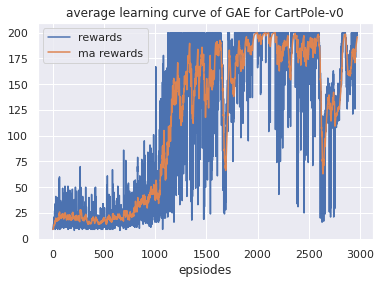

Start Evaluating!
20210804-140536
[20210804-140537: GAE] Episode:4: Frame:800.0: Reward:200.0
[20210804-140537: GAE] Episode:8: Frame:1600.0: Reward:200.0
[20210804-140538: GAE] Episode:12: Frame:2400.0: Reward:200.0
[20210804-140538: GAE] Episode:16: Frame:3200.0: Reward:200.0
[20210804-140539: GAE] Episode:20: Frame:4000.0: Reward:200.0
[20210804-140539: GAE] Episode:24: Frame:4800.0: Reward:200.0
[20210804-140540: GAE] Episode:28: Frame:5600.0: Reward:200.0
[20210804-140540: GAE] Episode:32: Frame:6400.0: Reward:200.0
[20210804-140540: GAE] Episode:36: Frame:7200.0: Reward:200.0
[20210804-140541: GAE] Episode:40: Frame:8000.0: Reward:200.0
[20210804-140541: GAE] Episode:44: Frame:8800.0: Reward:200.0
[20210804-140541: GAE] Episode:48: Frame:9600.0: Reward:200.0
results saved!


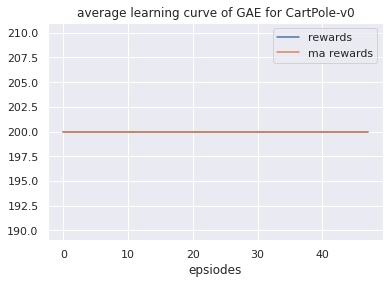

In [32]:
main()